# 作业八
利用Python编程实现Apriori算法

# Apriori算法原理

Apriori算法利用频繁项集性质的先验知识(prior-knowledge)，通过逐层搜索的迭代方法，即将k-项集用于探察(k+1)-项集，来穷尽数据集中的所有频繁项集。

算法步骤：

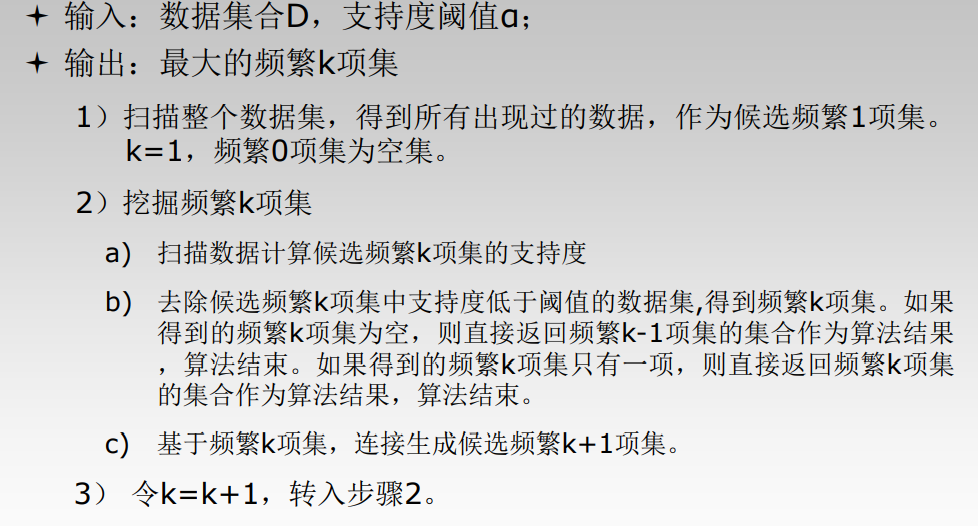

本次实现Apriori算法，主要分成三个步骤：加载数据、生成频繁项集、挖掘关联规则

# 导库

In [1]:
from numpy import *

# 参数设定
minSupport 最小支持度：小于最小支持度的集合将不会纳入频繁项集

minConf 最小置信度：小于最小置信度的关联规则不会被挖掘

In [2]:
minSupport = 0.5
minConf = 0.7

# 加载数据

In [3]:
def loadDataSet():
    return [[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]
dataSet = loadDataSet()

# 生成频繁项集

## 创造大小为1的所有候选项集的集合

In [4]:
# 创造候选项集C1，C1是大小为1的所有候选项集的集合
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    return list(map(frozenset, C1))

## 筛选满足要求的项集成为频繁项集

In [5]:
# 筛选满足要求的项集成为频繁项集Lk
def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                if not can in ssCnt:
                    ssCnt[can] = 1
                else:
                    ssCnt[can] += 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key]/numItems    # 计算支持度
        if support >= minSupport:   # 如果支持度大于设定的最小支持度
            retList.append(key)
        supportData[key] = support
    return retList, supportData

In [6]:
def aprioriGen(Lk, k):   
    lenLk = len(Lk)
    temp_dict = {}  
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            L1 = Lk[i] | Lk[j] 
            if len(L1) == k:
                # 把符合的新项存到字典的键中，使用字典可以去重复
                if not L1 in temp_dict:
                    temp_dict[L1] = 1
    return list(temp_dict)  # 把字典的键转化为列表

## 生成频繁项集列表

In [7]:
 # 得出频繁项集列表
def apriori(dataSet, minSupport): 
    C1 = createC1(dataSet) 
    D = list(map(set, dataSet))
    L1, supportData = scanD(D, C1, minSupport)  # 筛选出L1
    L = [L1]
    k = 2
    while (len(L[k-2]) > 0):   # 创造Ck
        Ck = aprioriGen(L[k-2], k)
        Lk, supK = scanD(D, Ck, minSupport)
        supportData.update(supK)
        L.append(Lk)
        k += 1
    return L, supportData

L为频繁项集列表,suppData为所有项集的支持度字典，其中筛选出大于minSupport作为L

In [8]:
L, suppData = apriori(dataSet, minSupport)
print("L=" + str(L))
print("suppData=" + str(suppData))

L=[[frozenset({1}), frozenset({3}), frozenset({2}), frozenset({5})], [frozenset({1, 3}), frozenset({2, 3}), frozenset({3, 5}), frozenset({2, 5})], [frozenset({2, 3, 5})], []]
suppData={frozenset({1}): 0.5, frozenset({3}): 0.75, frozenset({4}): 0.25, frozenset({2}): 0.75, frozenset({5}): 0.75, frozenset({1, 3}): 0.5, frozenset({2, 3}): 0.5, frozenset({3, 5}): 0.5, frozenset({2, 5}): 0.75, frozenset({1, 2}): 0.25, frozenset({1, 5}): 0.25, frozenset({2, 3, 5}): 0.5, frozenset({1, 2, 3}): 0.25, frozenset({1, 3, 5}): 0.25}


# 挖掘关联规则

## 筛选符合可信度要求的规则

In [9]:
# 筛选符合可信度要求的规则，并返回符合可信度要求的右件
def calcConf(freqSet, H, supportData, br1, minConf):  
    prunedH = [] 
    for conseq in H: 
        conf = supportData[freqSet]/supportData[freqSet-conseq]  # 计算可信度
        if conf >= minConf:
            print(freqSet-conseq, "-->", conseq, "\tconf:", conf)
            br1.append((freqSet-conseq, conseq, conf))
        else:
            prunedH.append(conseq)  # 不符合可信度的右件添加到列表中
    return prunedH

## 减少创造的规则

In [10]:
# 减少创造的规则
def rulesFromConseq(freqSet, H, supportData, br1, minConf): 
    is_find = True  # 循环标志
    m = 1  # 先创造右件为一个元素的规则
    # H是初始频繁项分散后的列表
    Hmp1 = H
    while is_find:
        if len(freqSet) > m:  
            if m > 1: 
                Hmp1 = aprioriGen(H, m) 
            # 筛选符合可信度的规则,把不符合的右件存起来
            H_no = calcConf(freqSet, Hmp1, supportData, br1, minConf)  
             # 如果有不满足可信度的右件
            if len(H_no) != 0: 
                H_no = list(set(frozenset([item])
                                for row in Hmp1 for item in row))
                H = list(set(H)-set(H_no)) 
            m = m + 1 
            if len(H) < m: 
                is_find = False
        else:  
            is_find = False

## 产生关联规则

In [11]:
# 产生关联规则
def generateRules(L, supportData, minConf): 
    bigRuleList = []
    for i in range(1, len(L)): 
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            if i > 1: 
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList

In [12]:
rules = generateRules(L, suppData, minConf)

frozenset({1}) --> frozenset({3}) 	conf: 1.0
frozenset({5}) --> frozenset({2}) 	conf: 1.0
frozenset({2}) --> frozenset({5}) 	conf: 1.0
frozenset({3, 5}) --> frozenset({2}) 	conf: 1.0
frozenset({2, 3}) --> frozenset({5}) 	conf: 1.0
